In [ ]:
import itertools
import torch
import torch.nn as nn
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from skorch import NeuralNetBinaryClassifier

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

dtype = torch.float
device = torch.device("cpu")

## Defining resources
We define some relevant functions and costant variables to use in this notebook.

In [ ]:
#function to compute the accuracy
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(y_pred)

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [ ]:
#define a function that split target column from dataset.
def split_train_test(df_monk_train, df_monk_test):
    target_train = df_monk_train[['class']]
    df_monk_train.drop(labels='class', axis=1, inplace=True)
    target_test = df_monk_test[['class']]
    df_monk_test.drop(labels='class', axis=1, inplace=True)
    X_train = df_monk_train.values #returns a ndarray
    y_train = target_train.values.ravel() #flattens the array into a 1-dimensional array
    X_test = df_monk_test.values
    y_test = target_test.values.ravel()

    return X_train, y_train, X_test, y_test

In [ ]:
#define mee loss function 
def mee(true_target, predicted_target):  # assuming target is 2-dim matrix with x and y as columns
    l = true_target.shape[0]
    res = 0

    for p in range(l):  # for p-th pattern in l (number of samples)
        x_diff = np.square(true_target[p, 0] - predicted_target[p, 0])  # difference between the x value of the true and predicted target
        y_diff = np.square(
            true_target[p, 1] - predicted_target[p, 1])  # difference between the y values of true and predicted target
        sum_term = x_diff + y_diff
        res = res + np.sqrt(sum_term)
    res = res / l

    return res

In [ ]:
#define a neural network
class BinaryClassification(nn.Module):
    def __init__(self, n_input = 6, hidden_units = 100):
        super(BinaryClassification, self).__init__()
        
        self.layer_in = nn.Linear(n_input, hidden_units)
        self.relu = nn.ReLU(inplace=True)
        self.layer_out = nn.Linear(hidden_units, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs, **kwargs):
        x = self.relu(self.layer_in(inputs))
        x = self.sigmoid(self.layer_out(x))


        return x

In [ ]:
#function to define the training phase
def TrainPhase(epochs, model, aggregated_losses, aggregated_accuracy, data_train, loss, optimizer):
    model.train()
    i = epochs

    epoch_loss = 0
    epoch_acc = 0
    
    for X_batch, y_batch in data_train:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
       
        y_pred = model(X_batch)
        
        single_loss = loss(y_pred, y_batch)fl
        acc = binary_acc(y_pred, y_batch)
            
        
        single_loss.backward()
        optimizer.step()
        
        epoch_loss += single_loss.item()
        epoch_acc += acc.item()
        
    aggregated_losses.append(epoch_loss/len(data_train))
    aggregated_accuracy.append((epoch_acc/len(data_train))/100)
    print(f'TRAIN - Epoch {i+0:03}: | Loss: {epoch_loss/len(data_train):.5f} | Acc: {epoch_acc/len(data_train):.3f}')
    
    return model, aggregated_losses, aggregated_accuracy

In [ ]:
#function to define the evaluating phase
def Evaluate(epochs, model, aggregated_losses, aggregated_accuracy, data_test, loss_f):
    
    i = epochs
    y_pred_list = []
    model.eval()
        
    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():
        for X_batch, y_batch in data_test:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_test_pred = model(X_batch)
            loss = loss_f(y_test_pred, y_batch)
            acc = binary_acc(y_test_pred, y_batch)
                
            epoch_loss += loss.item()
            epoch_acc += acc.item()

            #y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.detach().numpy())

    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    #flattens the lists in sequence
    ytest_pred = list(itertools.chain.from_iterable(y_pred_list))

    aggregated_losses.append(epoch_loss/len(data_test))
    aggregated_accuracy.append((epoch_acc/len(data_test))/100)
    #print(f'TEST - Epoch {i+0:03}: | Loss: {epoch_loss/len(data_test):.5f} | Acc: {epoch_acc/len(data_test):.3f}')
    print(f'VALIDATION - Epoch {i+0:03}: | Loss: {epoch_loss/len(data_test):.5f} | Acc: {epoch_acc/len(data_test):.3f}')
    
    return ytest_pred, aggregated_losses, aggregated_accuracy
    

In [ ]:
#function to define the evaluate phase
def Evaluate_Test(model, aggregated_losses, aggregated_accuracy, data_test, loss_f):

    y_pred_list = []
    model.eval()

    with torch.no_grad():
        for X_batch, y_batch in data_test:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_test_pred = model(X_batch)
            loss = loss_f(y_test_pred, y_batch)
            acc = binary_acc(y_test_pred, y_batch)
      
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.detach().numpy())

    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    #flattens the lists in sequence
    #ytest_pred = list(itertools.chain.from_iterable(y_pred_list))

    print(f'TEST - Loss: {loss.item():.5f} | Acc: {acc:.3f}')
    
    return y_pred_list, aggregated_losses, aggregated_accuracy

## Loading MONK-1 dataset
Now we load the first MONK dataset.

In [ ]:
#read train dataset
df_monk1_train = pd.read_csv('./data/MONK/monks-1.train', sep=" ", skipinitialspace=True, names=['class','a1','a2','a3','a4','a5','a6','id'])
df_monk1_train.drop(labels='id', axis=1, inplace=True)

#read test dataset
df_monk1_test = pd.read_csv('./data/MONK/monks-1.test', sep=" ", skipinitialspace=True,  names=['class','a1','a2','a3','a4','a5','a6','id'])
df_monk1_test.drop(labels='id', axis=1, inplace=True)

In [ ]:
df_monk1_test #first column is the target (can be either 0 or 1)

,class,a1,a2,a3,a4,a5,a6
0,1,1,1,1,1,1,1
1,1,1,1,1,1,1,2
2,1,1,1,1,1,2,1
3,1,1,1,1,1,2,2
4,1,1,1,1,1,3,1
...,...,...,...,...,...,...,...
427,1,3,3,2,3,2,2
428,1,3,3,2,3,3,1
429,1,3,3,2,3,3,2
430,1,3,3,2,3,4,1


In [ ]:
df_monk1_train

,class,a1,a2,a3,a4,a5,a6
0,1,1,1,1,1,3,1
1,1,1,1,1,1,3,2
2,1,1,1,1,3,2,1
3,1,1,1,1,3,3,2
4,1,1,1,2,1,2,1
...,...,...,...,...,...,...,...
119,1,3,3,2,1,4,2
120,1,3,3,2,3,1,2
121,1,3,3,2,3,2,2
122,1,3,3,2,3,3,2


<AxesSubplot:ylabel='class'>

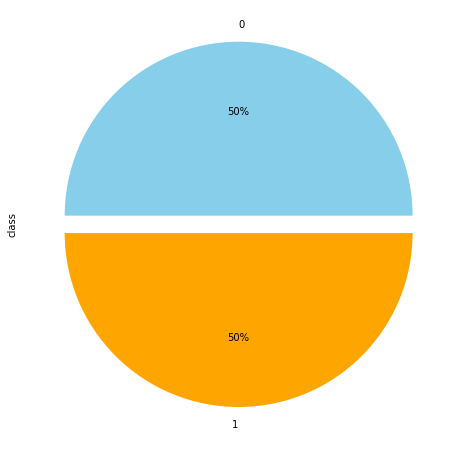

In [ ]:
#plot class distribution in train data
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

df_monk1_train['class'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['skyblue', 'orange'], explode=(0.05, 0.05))

<AxesSubplot:ylabel='class'>

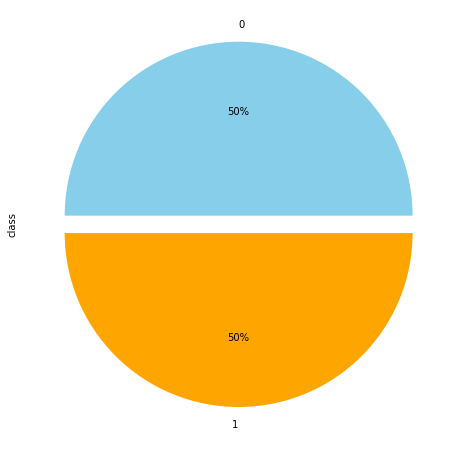

In [ ]:
#plot class distribution in test data
df_monk1_test['class'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['skyblue', 'orange'], explode=(0.05, 0.05))

In [ ]:
X_train_M1, y_train_M1, X_test_M1, y_test_M1 = split_train_test(df_monk1_train, df_monk1_test)

In [ ]:
#prepare validation set
#X_train, X_validation, y_train, y_validation = train_test_split(df_monk1_train, target_train, stratify=target_train, test_size=0.30)

In [ ]:
#print("Length train data: ", X_train.shape[0])
#print("Length validation data: ", X_validation.shape[0])

In [ ]:
#create tensor for train and test data 
#X_train = X_train.values #returns a ndarray
#X_test = X_test.values
#X_validation = X_validation.values

x_tensor =  torch.from_numpy(X_train_M1).float()
y_tensor =  torch.from_numpy(y_train_M1).float()
#xval_tensor =  torch.from_numpy(X_validation).float()
#yval_tensor =  torch.from_numpy(y_validation.values.ravel()).float()
xtest_tensor =  torch.from_numpy(X_test_M1).float()
ytest_tensor =  torch.from_numpy(y_test_M1).float()

### Model selection with skorch and sklearn
In this part, use skorch and sklearn to find the best model with randomizedsearch (or gridsearch)

In [ ]:
#cast train set and test set to Float
X_trainFit = X_train_M1.astype(np.single)
y_trainFit = y_train_M1.astype(np.single)

X_testFit = X_test_M1.astype(np.single)
y_testFit = y_test_M1.astype(np.single)

In [ ]:
net = NeuralNetBinaryClassifier(
    BinaryClassification,
    max_epochs=10,
    #batch_size = 1,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    train_split=None
)

# deactivate skorch-internal train-valid split and verbose logging
net.set_params(train_split=False, verbose=0)

params = {
    'lr': [0.0001, 0.001, 0.01, 0.1],
    'max_epochs': [10, 20, 30, 40, 50, 60, 70,  80, 90, 100],
    'optimizer': [torch.optim.SGD],
    #'criterion': [nn.BCELoss],
    'optimizer__momentum': [0.8, 0.9, 0.95, 0.85],
    'optimizer__weight_decay': [0.0001, 0.001, 0.01, 0.1],
    'optimizer__nesterov': [False, True],
    'module__hidden_units': [2, 3, 4, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'batch_size': [32, 64, 124, 128],
}
gs = RandomizedSearchCV(net, params, n_jobs=-1, refit=True, cv=None, n_iter=50, scoring='accuracy', verbose=2)

gs.fit(X_trainFit, y_trainFit)
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))

grid_predictions = gs.predict(X_testFit1) 
# print classification report 
print(classification_report(y_testFit, grid_predictions)) 

Fitting 5 folds for each of 50 candidates, totalling 250 fits
best score: nan, best params: {'optimizer__weight_decay': 0.1, 'optimizer__nesterov': False, 'optimizer__momentum': 0.8, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'module__hidden_units': 4, 'max_epochs': 20, 'lr': 0.001, 'criterion': <class 'torch.nn.modules.loss.BCELoss'>, 'batch_size': 64}


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
best_model = gs.best_estimator_
best_model.fit(X_trainFit, y_trainFit)
#y_pred = best_model.predict(X_trainFit)
best_model.score(X_testFit, y_testFit)

0.5

In [ ]:
BATCH_SIZE = best_model.batch_size
LEARNING_RATE = best_model.lr
MOMENTUM = best_model.optimizer__momentum
NESTEROV = best_model.optimizer__nesterov
L2 = best_model.optimizer__weight_decay
EPOCHS = best_model.max_epochs
UNITS = best_model.module__hidden_units
OPTIMIZER = best_model.optimizer

In [ ]:
df_results = pd.DataFrame(data=gs.cv_results_) #trasform into a pandas dataframe
df_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_optimizer__weight_decay,param_optimizer__nesterov,param_optimizer__momentum,param_optimizer,param_module__hidden_units,param_max_epochs,...,param_batch_size,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.527689,0.027827,0.014345,0.024180,0.1,True,0.9,<class 'torch.optim.sgd.SGD'>,100,40,...,64,"{'optimizer__weight_decay': 0.1, 'optimizer__n...",0.52,0.52,0.48,0.48,0.5,0.5,0.017889,1
1,1.796222,0.127400,0.010082,0.016318,0.0001,True,0.9,<class 'torch.optim.sgd.SGD'>,20,90,...,32,"{'optimizer__weight_decay': 0.0001, 'optimizer...",0.52,0.52,0.48,0.48,0.5,0.5,0.017889,1
2,0.839557,0.040130,0.001940,0.000025,0.0001,False,0.95,<class 'torch.optim.sgd.SGD'>,30,80,...,124,"{'optimizer__weight_decay': 0.0001, 'optimizer...",0.52,0.52,0.48,0.48,0.5,0.5,0.017889,1
3,0.312196,0.006956,0.024288,0.027391,0.01,False,0.95,<class 'torch.optim.sgd.SGD'>,50,30,...,128,"{'optimizer__weight_decay': 0.01, 'optimizer__...",0.52,0.52,0.48,0.48,0.5,0.5,0.017889,1
4,0.113336,0.046345,0.002295,0.000843,0.0001,True,0.85,<class 'torch.optim.sgd.SGD'>,5,10,...,124,"{'optimizer__weight_decay': 0.0001, 'optimizer...",0.52,0.52,0.48,0.48,0.5,0.5,0.017889,1
5,1.239959,0.074307,0.001697,0.000302,0.1,False,0.8,<class 'torch.optim.sgd.SGD'>,40,100,...,64,"{'optimizer__weight_decay': 0.1, 'optimizer__n...",0.52,0.52,0.48,0.48,0.5,0.5,0.017889,1
6,1.173551,0.095351,0.002342,0.000446,0.001,False,0.8,<class 'torch.optim.sgd.SGD'>,3,60,...,32,"{'optimizer__weight_decay': 0.001, 'optimizer_...",0.52,0.52,0.48,0.48,0.5,0.5,0.017889,1
7,0.613952,0.056307,0.001852,0.000064,0.001,False,0.95,<class 'torch.optim.sgd.SGD'>,90,30,...,32,"{'optimizer__weight_decay': 0.001, 'optimizer_...",0.52,0.52,0.48,0.48,0.5,0.5,0.017889,1
8,0.922635,0.025863,0.013944,0.024309,0.001,True,0.85,<class 'torch.optim.sgd.SGD'>,3,90,...,124,"{'optimizer__weight_decay': 0.001, 'optimizer_...",0.52,0.52,0.48,0.48,0.5,0.5,0.017889,1
9,0.415943,0.026779,0.001906,0.000082,0.001,False,0.8,<class 'torch.optim.sgd.SGD'>,10,40,...,124,"{'optimizer__weight_decay': 0.001, 'optimizer_...",0.52,0.52,0.48,0.48,0.5,0.5,0.017889,1


Now we check the result that achieved from randomizedsearch

In [ ]:
net = NeuralNetBinaryClassifier(
    BinaryClassification,
    module__hidden_units=UNITS,
    max_epochs=EPOCHS,
    batch_size = BATCH_SIZE,
    lr = LEARNING_RATE,
    optimizer=OPTIMIZER,
    optimizer__momentum=MOMENTUM,
    optimizer__nesterov=NESTEROV,
    optimizer__weight_decay=L2,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    train_split=None
)

net.fit(X_trainFit, y_trainFit, verbose=0)

  epoch    train_loss     dur
-------  ------------  ------
      1        0.7068  0.0638
      2        0.6921  0.0052
      3        0.6884  0.0063
      4        0.6865  0.0062
      5        0.6854  0.0056
      6        0.6854  0.0623
      7        0.6862  0.0056
      8        0.6892  0.0063
      9        0.6925  0.0060
     10        0.6969  0.0063
     11        0.7003  0.0062
     12        0.7044  0.0057
     13        0.7056  0.0068
     14        0.7061  0.0064
     15        0.7051  0.0063
     16        0.7035  0.0071
     17        0.7018  0.0649
     18        0.7001  0.0059
     19        0.6986  0.0057
     20        0.6976  0.0059
     21        0.6966  0.0059
     22        0.6961  0.0628
     23        0.6963  0.0063
     24        0.6961  0.0053
     25        0.6962  0.0058
     26        0.6963  0.0057
     27        0.6966  0.0061
     28        0.6967  0.0608
     29        0.6969  0.0058
     30        0.6974  0.0080
     31        0.6974  0.0083
     32   

<class 'skorch.classifier.NeuralNetBinaryClassifier'>[initialized](
  module_=BinaryClassification(
    (layer_in): Linear(in_features=6, out_features=100, bias=True)
    (relu): ReLU(inplace=True)
    (layer_out): Linear(in_features=100, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  ),
)

In [ ]:
net = NeuralNetBinaryClassifier(
    BinaryClassification,
    module__hidden_units=100,
    max_epochs=100,
    batch_size = 1,
    lr = 0.001,
    optimizer=torch.optim.Adam,
    #optimizer__momentum=0.95,
    #optimizer__nesterov=False,
    optimizer__weight_decay=0.1,
    optimizer__eps=1e-08,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    train_split=None
)

net.fit(X_trainFit, y_trainFit, verbose=0)

  epoch    train_loss     dur
-------  ------------  ------
      1        0.7040  0.3251
      2        0.6996  0.3896
      3        0.6963  0.3948
      4        0.6989  0.3756
      5        0.6991  0.3352
      6        0.6983  0.3962
      7        0.6984  0.3741
      8        0.6988  0.3269
      9        0.6982  0.3902
     10        0.7026  0.3722
     11        0.6972  0.3228
     12        0.6993  0.3648
     13        0.6986  0.3982
     14        0.6985  0.3306
     15        0.6991  0.3737
     16        0.6985  0.3969
     17        0.6991  0.3122
     18        0.7007  0.2707
     19        0.6965  0.2076
     20        0.6986  0.2058
     21        0.6999  0.2076
     22        0.6993  0.2075
     23        0.7000  0.2661
     24        0.7003  0.2148
     25        0.6979  0.2147
     26        0.6962  0.2091
     27        0.7024  0.2192
     28        0.6986  0.2144
     29        0.6983  0.2058
     30        0.6986  0.2715
     31        0.6984  0.2088
     32   

<class 'skorch.classifier.NeuralNetBinaryClassifier'>[initialized](
  module_=BinaryClassification(
    (layer_in): Linear(in_features=6, out_features=100, bias=True)
    (relu): ReLU(inplace=True)
    (layer_out): Linear(in_features=100, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  ),
)

## Testing model
In this section, we plot the results.

In [ ]:
#prepare dataloader for training
y_tensor = y_tensor.unsqueeze(1)
train_ds = TensorDataset(x_tensor, y_tensor)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

#prepare dataloader for evaluating 
ytest_tensor = ytest_tensor.unsqueeze(1)
test_ds = TensorDataset(xtest_tensor, ytest_tensor)
val_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

In [ ]:
#define the model
model = BinaryClassification(X_train_M1.shape[1], UNITS)
model.to(device)
print(model)

BinaryClassification(
  (layer_in): Linear(in_features=6, out_features=100, bias=True)
  (relu): ReLU(inplace=True)
  (layer_out): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
#define the loss function 
loss_function = nn.BCELoss(reduction='mean')
#define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=L2, nesterov=NESTEROV)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

After that defined the model, we start the training and evaluating process with prefixed number of epochs. Each epoch, we save the results on lists for plotting the train and evaluate trends.  

In [ ]:
#prepare empty lists to store accuracy and loss results
losses_train = []
accuracies_train = []
losses_test = []
accuracies_test = []

#train and evaluate for each epoch
for epoch in range(1,EPOCHS+1): 

  model, losses_train, accuracies_train = TrainPhase(epoch, model, losses_train, accuracies_train, train_loader, loss_function, optimizer)
  #y_pred_test, losses_test, accuracies_test = Evaluate(epoch, model, losses_test, accuracies_test, test_loader, loss_function)
  y_pred_test, losses_test, accuracies_test = Evaluate(epoch, model, losses_test, accuracies_test, val_loader, loss_function)
  
  print("##############################")


TRAIN - Epoch 001: | Loss: 0.71939 | Acc: 45.500
VALIDATION - Epoch 001: | Loss: 0.70550 | Acc: 52.857
##############################
TRAIN - Epoch 002: | Loss: 0.73501 | Acc: 51.500
VALIDATION - Epoch 002: | Loss: 0.94832 | Acc: 50.000
##############################
TRAIN - Epoch 003: | Loss: 0.86222 | Acc: 50.000
VALIDATION - Epoch 003: | Loss: 0.63447 | Acc: 63.571
##############################
TRAIN - Epoch 004: | Loss: 0.55197 | Acc: 71.000
VALIDATION - Epoch 004: | Loss: 0.62853 | Acc: 63.286
##############################
TRAIN - Epoch 005: | Loss: 0.53639 | Acc: 71.000
VALIDATION - Epoch 005: | Loss: 0.61116 | Acc: 70.000
##############################
TRAIN - Epoch 006: | Loss: 0.53078 | Acc: 75.000
VALIDATION - Epoch 006: | Loss: 0.60320 | Acc: 70.143
##############################
TRAIN - Epoch 007: | Loss: 0.53504 | Acc: 73.000
VALIDATION - Epoch 007: | Loss: 0.59995 | Acc: 70.571
##############################
TRAIN - Epoch 008: | Loss: 0.54450 | Acc: 73.500
VALIDATION - 

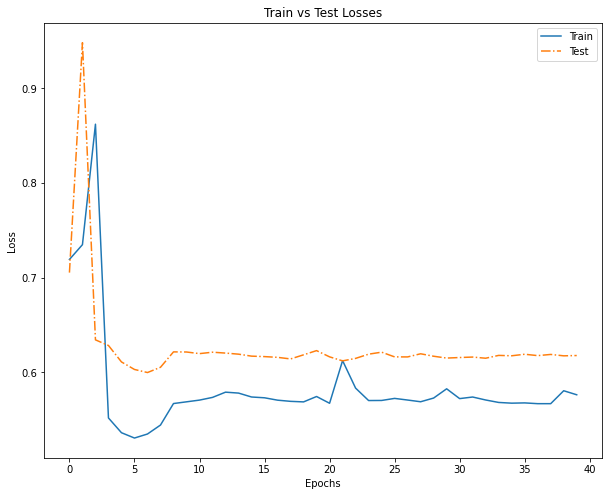

In [ ]:
#create a loss plot
plt.plot(losses_train,'-')
plt.plot(losses_test,'-.')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train','Test'])
plt.title('Train vs Test Losses')
 
plt.show()

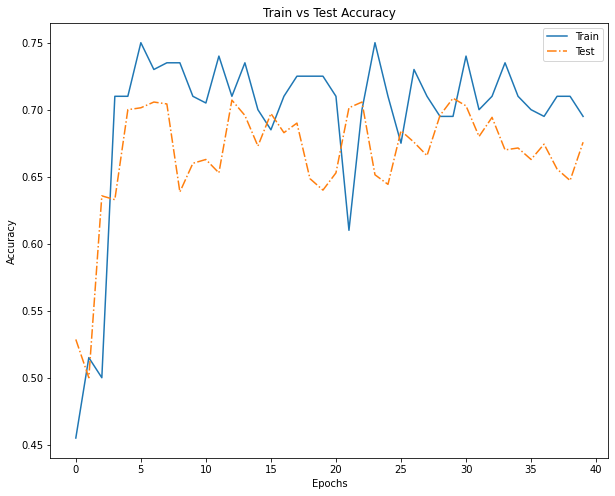

In [ ]:
#create an accuracy plot
plt.plot(accuracies_train,'-')
plt.plot(accuracies_test,'-.')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'])
plt.title('Train vs Test Accuracy')
 
plt.show()

In [ ]:
y_pred_test, losses_test, accuracies_test = Evaluate_Test(model, losses_test, accuracies_test, test_loader, loss_function)

#control the accuracy between true and predict values on test data
print(classification_report(y_test_M1, y_pred_test))

TEST - Loss: 0.82578 | Acc: 0.000
              precision    recall  f1-score   support

           0       0.67      0.72      0.69       216
           1       0.70      0.64      0.67       216

    accuracy                           0.68       432
   macro avg       0.68      0.68      0.68       432
weighted avg       0.68      0.68      0.68       432



### One hot encoding in MONK-1
In the MONK dataset we have the categories encoded using label encoding (e.g. 0,1,2,..), we need to use one hot encoding in order to have better results (e.g. 001, 010, ..). 

In [ ]:
enc_train = OneHotEncoder()
enc_train.fit(X_train_M1)
X_train_M1 = enc_train.transform(X_train_M1).toarray()
print(X_train_M1.shape)

enc_test = OneHotEncoder()
enc_test.fit(X_test_M1)
X_test_M1 = enc_test.transform(X_test_M1).toarray()
print(X_test_M1.shape)

x_tensor =  torch.from_numpy(X_train_M1).float()
y_tensor =  torch.from_numpy(y_train_M1).float()
#xval_tensor =  torch.from_numpy(X_validation).float()
#yval_tensor =  torch.from_numpy(y_validation.values.ravel()).float()
xtest_tensor =  torch.from_numpy(X_test_M1).float()
ytest_tensor =  torch.from_numpy(y_test_M1).float()

(124, 17)
(432, 17)


In [ ]:
net = NeuralNetBinaryClassifier(
    BinaryClassification,
    max_epochs=10,
    #batch_size = 1,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    train_split=None
)

# deactivate skorch-internal train-valid split and verbose logging
net.set_params(train_split=False, verbose=0)

params = {
    'lr': [0.0001, 0.001, 0.01, 0.1],
    'max_epochs': [10, 20, 30, 40, 50, 60, 70,  80, 90, 100],
    'optimizer': [torch.optim.SGD],
    'optimizer__momentum': [0.8, 0.9, 0.95, 0.85],
    'optimizer__weight_decay': [0.0001, 0.001, 0.01, 0.1],
    'optimizer__nesterov': [False, True],
    'module__hidden_units': [2, 3, 4, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'batch_size': [32, 64, 124, 128],
}
gs = RandomizedSearchCV(net, params, n_jobs=-1, refit=True, cv=None, n_iter=50, scoring='accuracy', verbose=2)

gs.fit(X_trainFit, y_trainFit)
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))

grid_predictions = gs.predict(X_testFit) 
# print classification report 
print(classification_report(y_testFit, grid_predictions)) 

Fitting 5 folds for each of 50 candidates, totalling 250 fits
best score: 0.524, best params: {'optimizer__weight_decay': 0.001, 'optimizer__nesterov': False, 'optimizer__momentum': 0.95, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'module__hidden_units': 100, 'max_epochs': 100, 'lr': 0.1, 'batch_size': 32}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       216
         1.0       0.50      1.00      0.67       216

    accuracy                           0.50       432
   macro avg       0.25      0.50      0.33       432
weighted avg       0.25      0.50      0.33       432



In [ ]:
best_model = gs.best_estimator_
best_model.fit(X_trainFit, y_trainFit)
#y_pred = best_model.predict(X_trainFit)
best_model.score(X_testFit, y_testFit)

0.49074074074074076

In [ ]:
BATCH_SIZE = best_model.batch_size
LEARNING_RATE = best_model.lr
MOMENTUM = best_model.optimizer__momentum
NESTEROV = best_model.optimizer__nesterov
L2 = best_model.optimizer__weight_decay
EPOCHS = best_model.max_epochs
UNITS = best_model.module__hidden_units
OPTIMIZER = best_model.optimizer

In [ ]:
net = NeuralNetBinaryClassifier(
    BinaryClassification,
    module__hidden_units=UNITS,
    max_epochs=EPOCHS,
    batch_size = BATCH_SIZE,
    lr = LEARNING_RATE,
    optimizer=OPTIMIZER,
    optimizer__momentum=MOMENTUM,
    optimizer__nesterov=NESTEROV,
    optimizer__weight_decay=L2,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    train_split=None
)

net.fit(X_trainFit, y_trainFit, verbose=0)

  epoch    train_loss     dur
-------  ------------  ------
      1        0.7009  0.0106
      2        0.6846  0.0082
      3        0.6820  0.0073
      4        0.6742  0.0620
      5        0.6426  0.0082
      6        0.6498  0.0074
      7        0.6398  0.0081
      8        0.6345  0.0074
      9        0.6312  0.0081
     10        0.6133  0.0073
     11        0.6172  0.0075
     12        0.6110  0.0081
     13        0.6076  0.0648
     14        0.6094  0.0079
     15        0.6045  0.0077
     16        0.6039  0.0070
     17        0.6049  0.0080
     18        0.6018  0.0082
     19        0.6018  0.0084
     20        0.6019  0.0081
     21        0.6005  0.0081
     22        0.6004  0.0651
     23        0.6002  0.0082
     24        0.5999  0.0089
     25        0.5993  0.0082
     26        0.5998  0.0649
     27        0.5991  0.0078
     28        0.5983  0.0111
     29        0.5992  0.0087
     30        0.5999  0.0638
     31        0.5988  0.0076
     32   

<class 'skorch.classifier.NeuralNetBinaryClassifier'>[initialized](
  module_=BinaryClassification(
    (layer_in): Linear(in_features=6, out_features=100, bias=True)
    (relu): ReLU(inplace=True)
    (layer_out): Linear(in_features=100, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  ),
)

net = NeuralNetBinaryClassifier(
    BinaryClassification,
    module__hidden_units=5,
    max_epochs=500,
    batch_size = 1,
    lr = 0.0001,
    optimizer=torch.optim.Adam,
    #optimizer__momentum=0.95,
    #optimizer__nesterov=True,
    #optimizer__weight_decay=0.01,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    train_split=None
)

net.fit(X_trainFit, y_trainFit, verbose=0)

In [ ]:
#prepare dataloader for training
y_tensor = y_tensor.unsqueeze(1)
train_ds = TensorDataset(x_tensor, y_tensor)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

#prepare dataloader for evaluating 
ytest_tensor = ytest_tensor.unsqueeze(1)
test_ds = TensorDataset(xtest_tensor, ytest_tensor)
val_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

In [ ]:
#define the model
model = BinaryClassification(X_train_M1.shape[1], UNITS)
model.to(device)

#define the loss function 
loss_function = nn.BCELoss(reduction='mean')
#define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=L2, nesterov=NESTEROV)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

#prepare empty lists to store accuracy and loss results
losses_train = []
accuracies_train = []
losses_test = []
accuracies_test = []

#train and evaluate for each epoch
for epoch in range(1,EPOCHS+1): 

  model, losses_train, accuracies_train = TrainPhase(epoch, model, losses_train, accuracies_train, train_loader, loss_function, optimizer)
  #y_pred_test, losses_test, accuracies_test = Evaluate(epoch, model, losses_test, accuracies_test, test_loader, loss_function)
  y_pred_test, losses_test, accuracies_test = Evaluate(epoch, model, losses_test, accuracies_test, val_loader, loss_function)
  
  print("##############################")

TRAIN - Epoch 001: | Loss: 0.68790 | Acc: 54.250
VALIDATION - Epoch 001: | Loss: 0.67771 | Acc: 65.714
##############################
TRAIN - Epoch 002: | Loss: 0.64833 | Acc: 72.250
VALIDATION - Epoch 002: | Loss: 0.64465 | Acc: 71.071
##############################
TRAIN - Epoch 003: | Loss: 0.57997 | Acc: 80.750
VALIDATION - Epoch 003: | Loss: 0.60972 | Acc: 69.000
##############################
TRAIN - Epoch 004: | Loss: 0.51182 | Acc: 78.250
VALIDATION - Epoch 004: | Loss: 0.58989 | Acc: 71.214
##############################
TRAIN - Epoch 005: | Loss: 0.46553 | Acc: 79.750
VALIDATION - Epoch 005: | Loss: 0.58183 | Acc: 70.286
##############################
TRAIN - Epoch 006: | Loss: 0.42024 | Acc: 82.500
VALIDATION - Epoch 006: | Loss: 0.58186 | Acc: 74.500
##############################
TRAIN - Epoch 007: | Loss: 0.40506 | Acc: 84.750
VALIDATION - Epoch 007: | Loss: 0.58882 | Acc: 71.286
##############################
TRAIN - Epoch 008: | Loss: 0.38727 | Acc: 81.500
VALIDATION - 

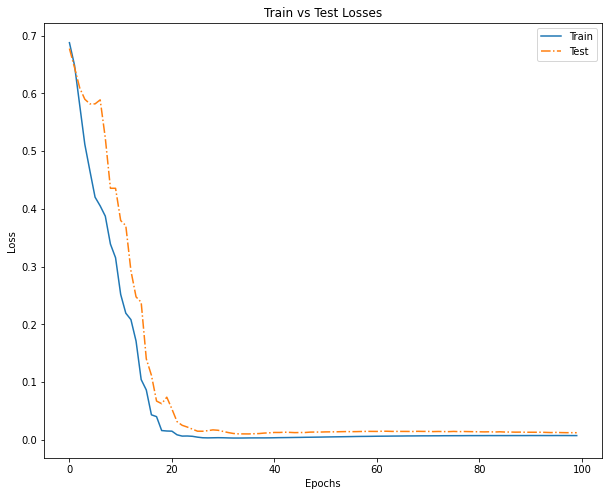

In [ ]:
#create a loss plot
plt.plot(losses_train,'-')
plt.plot(losses_test,'-.')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train','Test'])
plt.title('Train vs Test Losses')
 
plt.show()

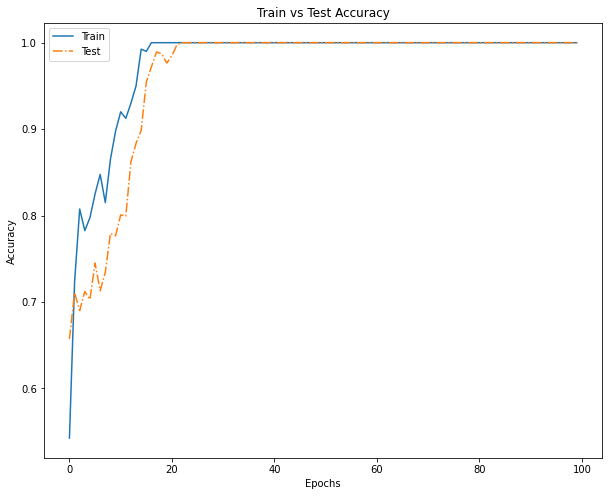

In [ ]:
#create an accuracy plot
plt.plot(accuracies_train,'-')
plt.plot(accuracies_test,'-.')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'])
plt.title('Train vs Test Accuracy')
 
plt.show()

### Loading MONK-2 dataset

In [ ]:
df_monk2_train = pd.read_csv('./data/MONK/monks-2.train', sep=" ", skipinitialspace=True, names=['class','a1','a2','a3','a4','a5','a6','id'])
df_monk2_train.drop(labels='id', axis=1, inplace=True)

df_monk2_test = pd.read_csv('./data/MONK/monks-2.test', sep=" ", skipinitialspace=True,  names=['class','a1','a2','a3','a4','a5','a6','id'])
df_monk2_test.drop(labels='id', axis=1, inplace=True)

In [ ]:
df_monk2_test.head() #first column is the target (can be either 0 or 1)

,class,a1,a2,a3,a4,a5,a6
0,0,1,1,1,1,1,1
1,0,1,1,1,1,1,2
2,0,1,1,1,1,2,1
3,0,1,1,1,1,2,2
4,0,1,1,1,1,3,1


In [ ]:
df_monk2_train

,class,a1,a2,a3,a4,a5,a6
0,0,1,1,1,1,2,2
1,0,1,1,1,1,4,1
2,0,1,1,1,2,1,1
3,0,1,1,1,2,1,2
4,0,1,1,1,2,2,1
...,...,...,...,...,...,...,...
164,0,3,3,2,2,3,1
165,0,3,3,2,2,3,2
166,1,3,3,2,3,1,1
167,0,3,3,2,3,2,1


<AxesSubplot:ylabel='class'>

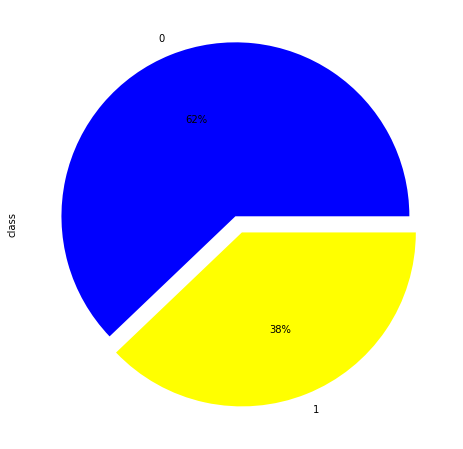

In [ ]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

df_monk2_train['class'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['blue', 'yellow'], explode=(0.05, 0.05))

<AxesSubplot:ylabel='class'>

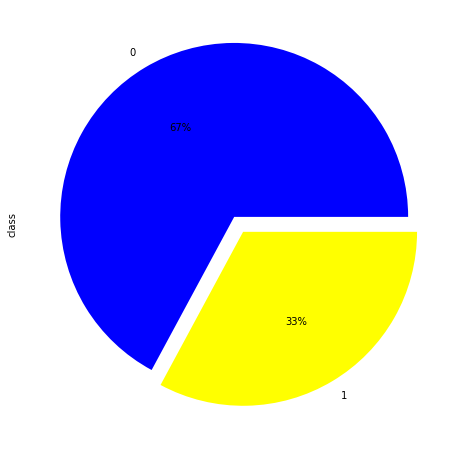

In [ ]:
df_monk2_test['class'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['blue', 'yellow'], explode=(0.05, 0.05))

In [ ]:
target_train = df_monk2_train.pop('class')
target_test = df_monk2_test.pop('class')
X_train = df_monk2_train
y_train = target_train
X_test = df_monk2_test
y_test = target_test

In [ ]:
X_train = X_train.values #returns a ndarray
X_test = X_test.values
x_tensor =  torch.from_numpy(X_train).float()
y_tensor =  torch.from_numpy(y_train.values.ravel()).float()
xtest_tensor =  torch.from_numpy(X_test).float()
ytest_tensor =  torch.from_numpy(y_test.values.ravel()).float()

In [ ]:
y_tensor = y_tensor.unsqueeze(1)
train_ds = TensorDataset(x_tensor, y_tensor)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE)

In [ ]:
ytest_tensor = ytest_tensor.unsqueeze(1)
test_ds = TensorDataset(xtest_tensor, ytest_tensor)
test_loader = DataLoader(test_ds, batch_size=64)

In [ ]:
model = BinaryClassification(X_train.shape[1], 100)

In [ ]:
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
losses_train = []
accuracies_train = []
losses_test = []
accuracies_test = []

for epoch in range(1,EPOCHS+1): 
  model, losses_train, accuracies_train = TrainPhase(epoch, model, losses_train, accuracies_train, train_loader, loss_function, optimizer)
  y_pred_test, losses_test, accuracies_test = Evaluate(epoch, model, losses_test, accuracies_test, test_loader, loss_function)
  print("##############################")

TRAIN - Epoch 001: | Loss: 2.33606 | Acc: 43.167
VALIDATION - Epoch 001: | Loss: 0.71190 | Acc: 65.714
##############################
TRAIN - Epoch 002: | Loss: 1.00487 | Acc: 52.667
VALIDATION - Epoch 002: | Loss: 0.97556 | Acc: 35.429
##############################
TRAIN - Epoch 003: | Loss: 0.88875 | Acc: 52.000
VALIDATION - Epoch 003: | Loss: 0.89910 | Acc: 33.286
##############################
TRAIN - Epoch 004: | Loss: 0.71754 | Acc: 48.333
VALIDATION - Epoch 004: | Loss: 0.71507 | Acc: 65.429
##############################
TRAIN - Epoch 005: | Loss: 0.73492 | Acc: 63.000
VALIDATION - Epoch 005: | Loss: 0.83917 | Acc: 67.000
##############################
TRAIN - Epoch 006: | Loss: 0.95249 | Acc: 55.000
VALIDATION - Epoch 006: | Loss: 1.06072 | Acc: 36.143
##############################
TRAIN - Epoch 007: | Loss: 0.87357 | Acc: 55.167
VALIDATION - Epoch 007: | Loss: 0.81399 | Acc: 36.286
##############################
TRAIN - Epoch 008: | Loss: 0.71955 | Acc: 50.000
VALIDATION - 

In [ ]:
y_true_test = y_test.values.ravel()
print(classification_report(y_true_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.67      0.92      0.78       290
           1       0.29      0.06      0.10       142

    accuracy                           0.64       432
   macro avg       0.48      0.49      0.44       432
weighted avg       0.54      0.64      0.55       432



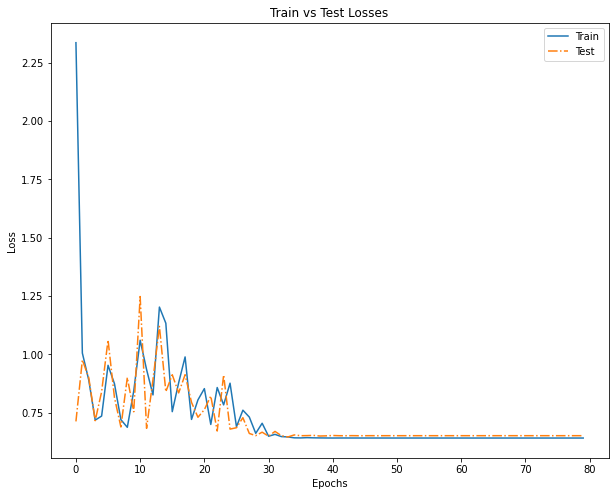

In [ ]:
plt.plot(losses_train,'-')
plt.plot(losses_test,'-.')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train','Test'])
plt.title('Train vs Test Losses')
 
plt.show()

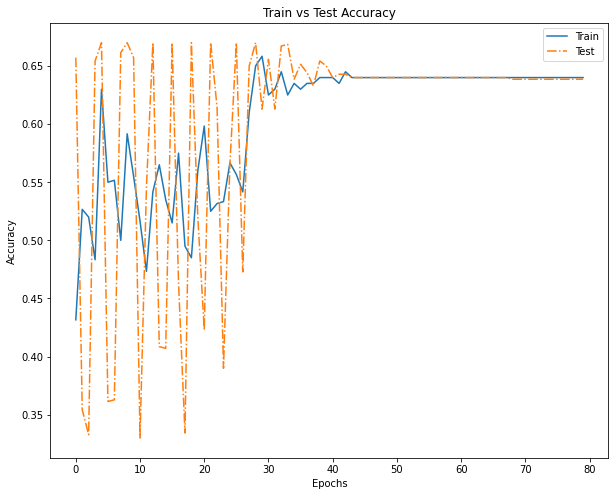

In [ ]:
plt.plot(accuracies_train,'-')
plt.plot(accuracies_test,'-.')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'])
plt.title('Train vs Test Accuracy')
 
plt.show()

## Loading MONK-3 dataset

In [ ]:
#read train dataset
df_monk3_train = pd.read_csv('./data/MONK/monks-3.train', sep=" ", skipinitialspace=True, names=['class','a1','a2','a3','a4','a5','a6','id'])
df_monk3_train.drop(labels='id', axis=1, inplace=True)

#read test dataset
df_monk3_test = pd.read_csv('./data/MONK/monks-3.test', sep=" ", skipinitialspace=True,  names=['class','a1','a2','a3','a4','a5','a6','id'])
df_monk3_test.drop(labels='id', axis=1, inplace=True)

In [ ]:
df_monk3_train.head()

,class,a1,a2,a3,a4,a5,a6
0,1,1,1,1,1,1,2
1,1,1,1,1,1,2,1
2,1,1,1,1,1,2,2
3,0,1,1,1,1,3,1
4,0,1,1,1,1,4,1


In [ ]:
df_monk3_test.head()

,class,a1,a2,a3,a4,a5,a6
0,1,1,1,1,1,1,1
1,1,1,1,1,1,1,2
2,1,1,1,1,1,2,1
3,1,1,1,1,1,2,2
4,1,1,1,1,1,3,1


<AxesSubplot:ylabel='class'>

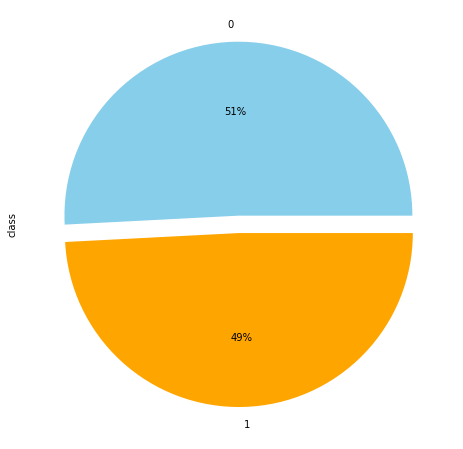

In [ ]:
#plot class distribution in train data
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

df_monk3_train['class'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['skyblue', 'orange'], explode=(0.05, 0.05))

<AxesSubplot:ylabel='class'>

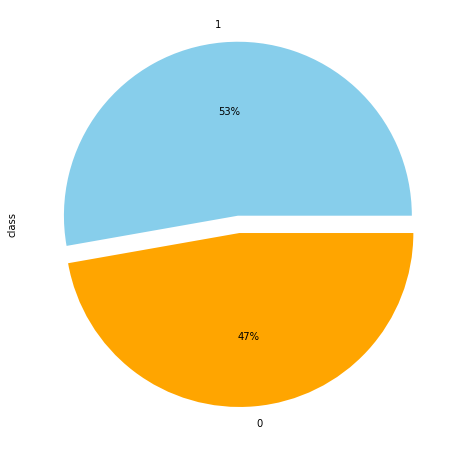

In [ ]:
#plot class distribution in test data
df_monk3_test['class'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['skyblue', 'orange'], explode=(0.05, 0.05))

In [ ]:
#prepare train and test data
target_train = df_monk3_train.pop('class')
target_test = df_monk3_test.pop('class')
X_train = df_monk3_train
y_train = target_train
X_test = df_monk3_test
y_test = target_test

In [ ]:
#create tensor for train and test data 
X_train = X_train.values #returns a ndarray
X_test = X_test.values
x_tensor =  torch.from_numpy(X_train).float()
y_tensor =  torch.from_numpy(y_train.values.ravel()).float()
xtest_tensor =  torch.from_numpy(X_test).float()
ytest_tensor =  torch.from_numpy(y_test.values.ravel()).float()

In [ ]:
#prepare dataloader for training
y_tensor = y_tensor.unsqueeze(1)
train_ds = TensorDataset(x_tensor, y_tensor)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE)

In [ ]:
#prepare dataloader for evaluating 
ytest_tensor = ytest_tensor.unsqueeze(1)
test_ds = TensorDataset(xtest_tensor, ytest_tensor)
test_loader = DataLoader(test_ds, batch_size=64)

In [ ]:
#define the model
model = BinaryClassification(X_train.shape[1], 100)

In [ ]:
#define the loss function 
loss_function = nn.BCELoss()
#define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=L2, dampening=DAMPENING, nesterov=NESTEROV)

NameError: name 'DAMPENING' is not defined

In [ ]:
#prepare empty lists to store accuracy and loss results
losses_train = []
accuracies_train = []
losses_test = []
accuracies_test = []

#train and evaluate for each epoch
for epoch in range(1,EPOCHS+1): 
  model, losses_train, accuracies_train = TrainPhase(epoch, model, losses_train, accuracies_train, train_loader, loss_function, optimizer)
  y_pred_test, losses_test, accuracies_test = Evaluate(epoch, model, losses_test, accuracies_test, test_loader, loss_function)
  print("##############################")


TRAIN - Epoch 001: | Loss: 0.68085 | Acc: 58.500
VALIDATION - Epoch 001: | Loss: 0.68353 | Acc: 58.143
##############################
TRAIN - Epoch 002: | Loss: 0.67941 | Acc: 56.500
VALIDATION - Epoch 002: | Loss: 0.68253 | Acc: 57.571
##############################
TRAIN - Epoch 003: | Loss: 0.67810 | Acc: 59.500
VALIDATION - Epoch 003: | Loss: 0.68161 | Acc: 57.714
##############################
TRAIN - Epoch 004: | Loss: 0.67689 | Acc: 60.500
VALIDATION - Epoch 004: | Loss: 0.68078 | Acc: 58.143
##############################
TRAIN - Epoch 005: | Loss: 0.67578 | Acc: 61.000
VALIDATION - Epoch 005: | Loss: 0.68001 | Acc: 57.429
##############################
TRAIN - Epoch 006: | Loss: 0.67475 | Acc: 60.000
VALIDATION - Epoch 006: | Loss: 0.67930 | Acc: 57.429
##############################
TRAIN - Epoch 007: | Loss: 0.67378 | Acc: 58.500
VALIDATION - Epoch 007: | Loss: 0.67864 | Acc: 57.000
##############################
TRAIN - Epoch 008: | Loss: 0.67288 | Acc: 57.000
VALIDATION - 

In [ ]:
#control the accuracy between true and predict values on test data
y_true_test = y_test.values.ravel()
print(classification_report(y_true_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.53      0.86      0.66       204
           1       0.72      0.32      0.44       228

    accuracy                           0.57       432
   macro avg       0.63      0.59      0.55       432
weighted avg       0.63      0.57      0.54       432



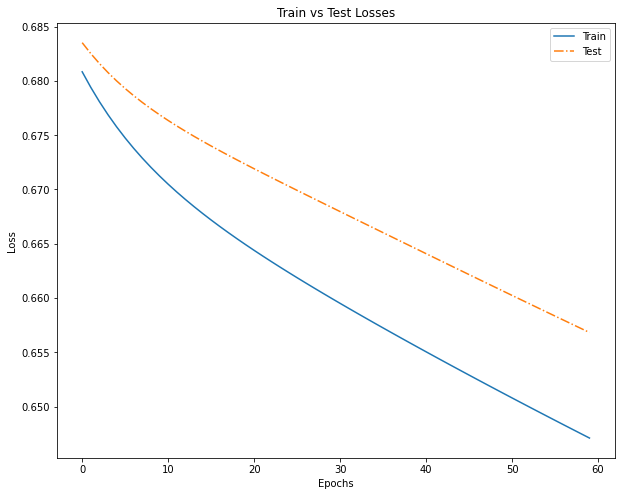

In [ ]:
plt.plot(losses_train,'-')
plt.plot(losses_test,'-.')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train','Test'])
plt.title('Train vs Test Losses')
 
plt.show()

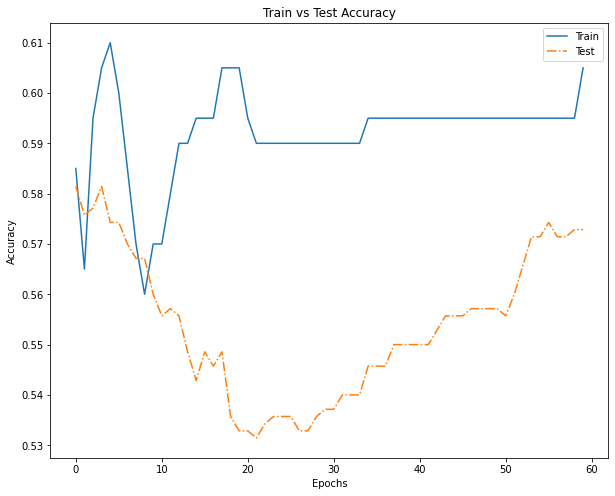

In [ ]:
#create an accuracy plot
plt.plot(accuracies_train,'-')
plt.plot(accuracies_test,'-.')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'])
plt.title('Train vs Test Accuracy')
 
plt.show()

## Defining model for regression task

In [ ]:
def mee(true_target, predicted_target): #assuming target is 2-dim matrix with x and y as columns
    l = true_target.shape[0]
    res = 0
    
    for p in range(l): #for p-th pattern in l (number of samples)
        x_diff = np.square(true_target[p,0] - predicted_target[p,0]) #difference between the x value of the true and predicted target
        y_diff = np.square(true_target[p,1] - predicted_target[p,1]) #difference between the y values of true and predicted target
        sum_term = x_diff + y_diff
        res = res + np.sqrt(sum_term)
    res = res / l
    
    #return np.average([np.sqrt(np.square(true_target[p,0] - predicted_target[p,0]) + np.square(true_target[p,1] - predicted_target[p,1])) for p in range(l)]) #compact form
    return res

In [ ]:
from sklearn.preprocessing import StandardScaler

class OutputDataset(Dataset):
    def __init__(self, X, y, scale_data=True):
        if not torch.is_tensor(X) and not torch.is_tensor(y):
            # Apply scaling if necessary
            if scale_data:
                X = StandardScaler().fit_transform(X)
                self.X = torch.from_numpy(X).float()
                y = torch.from_numpy(y).float()
                self.y = y.unsqueeze(1)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [ ]:
#define a neural network
class RegressionNet(nn.Module):
    def __init__(self, n_input, n_hidden1, n_hidden2, n_output):
        super(RegressionNet, self).__init__()
        self.layer_in = nn.Linear(n_input, n_hidden1)
        self.layer_1 = nn.Linear(n_hidden1, n_hidden2) 
        self.layer_out = nn.Linear(n_hidden2, n_output) 
        
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid =  nn.Sigmoid()
        #self.dropout = nn.Dropout(p=0.5)
        self.batchnorm1 = nn.BatchNorm1d(n_hidden1)
        self.batchnorm2 = nn.BatchNorm1d(n_hidden2)

    def forward(self, inputs):
        x = self.relu(self.layer_in(inputs))
        #x = self.batchnorm1(x)
        x = self.relu(self.layer_1(x))
        #x = self.batchnorm2(x)
        #x = self.dropout(x)

        x = self.layer_out(x)
        #out1 = self.last_fc(x)
        
        return x

In [ ]:
#function to define the train phase
def TrainPhase_Cup(epochs, model, aggregated_losses, aggregated_accuracy, data_train, loss, optimizer):
    model.train()
    i = epochs

    epoch_loss = 0
    epoch_acc = 0
    
    for X_batch, y_batch in data_train:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
       
        y_pred = model(X_batch)
        #y_pred1 = model(X_batch)
        
        single_loss = loss(y_pred, y_batch)
        #single_loss1 = loss1(y_pred1, y_batch1)
        #single_loss2 = loss2(y_pred2, y_batch2)
        #single_loss = torch.add(single_loss1, single_loss2)

        #acc = binary_acc(y_pred, y_batch)
             
        single_loss.backward()
        optimizer.step()
        
        epoch_loss += single_loss.item()
        #epoch_acc += acc.item()
        
    aggregated_losses.append(epoch_loss/len(data_train))
    #aggregated_accuracy.append((epoch_acc/len(data_train))/100)
    print(f'TRAIN - Epoch {i+0:03}: | Loss: {epoch_loss/len(data_train):.5f}')

    #aggregated_losses.append(single_loss.item())
    #aggregated_accuracy.append(acc/100)
    #print(f'TRAIN - Epoch {i+0:03}: | Loss: {single_loss.item():.5f} | Acc: {acc:.3f}')
    
    return model, aggregated_losses

In [ ]:
#function to define the evaluate phase
def Evaluate_Cup(epochs, model, aggregated_losses, aggregated_accuracy, data_test, loss_f):
    
    i = epochs
    y_pred_list = []
    model.eval()
        
    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():
        for X_batch, y_batch in data_test:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_test_pred = model(X_batch)
            #y_pred1, y_pred2 = model(X_batch)

            loss = loss_f(y_test_pred, y_batch)
            #loss1 = loss_f1(y_pred1, y_batch1)
            #loss2 = loss_f2(y_pred2, y_batch2)
            #loss = torch.add(loss1, loss2)
            
            #acc = binary_acc(y_test_pred, y_batch)

            epoch_loss += loss.item()
            #epoch_loss += loss.item()*X_batch.size(0)
            #epoch_acc += acc.item()

            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
    

    #y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

    aggregated_losses.append(epoch_loss/len(data_test))
    #aggregated_accuracy.append((epoch_acc/len(data_test))/100)
    #print(f'TEST - Epoch {i+0:03}: | Loss: {epoch_loss/len(data_test):.5f} | Acc: {epoch_acc/len(data_test):.3f}')
    print(f'VALIDATION - Epoch {i+0:03}: | Loss: {epoch_loss/len(data_test):.5f}')
    
    return aggregated_losses
    

In [ ]:
#function to define the evaluate phase
def Result_Cup(model, X_batch):
    
    y_pred_list = []
    model.eval()

    with torch.no_grad():
        #for X_batch, _ in data_test:
        X_batch = X_batch.to(device)

        y_test_pred = model(X_batch)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy()) 

    #y_pred_list = [a.squeeze().tolist() for a in y_pred_list]    
    return y_pred_list
    

## ML-Cup dataset

### Loading the training and blind test dataset

In [ ]:
df_visual = pd.read_csv('./data/ML-CUP21-TR.csv', usecols=[11,12], names=['idx','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10', 'x','y'])
df_task_tr = pd.read_csv('./data/ML-CUP21-TR.csv', names=['idx','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10', 'x','y'])
df_task_tr = df_task_tr[7:] # remove first 7 rows of comments
df_visual = df_visual[7:]

df_blind_ts = pd.read_csv('./data/ML-CUP21-TS.csv', names=['idx','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10'])
df_blind_ts = df_blind_ts[7:]
df_blind_ts.drop(labels="idx", axis=1, inplace=True)
#blind_ts = df_blind_ts.values

In [ ]:
df_task_tr.drop(labels="idx", axis=1, inplace=True)

In [ ]:
y = df_task_tr[['x','y']]
X = df_task_tr.drop(labels=['x','y'], axis=1)
X_test = df_blind_ts

print(y.shape)

(1477, 2)


### Internal Test set
We split the training set obtaining an internal test set composed of the 20% of the training set, we will use this internal test set to test the generalization error

In [ ]:
#prepare validation set
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.1, random_state=420)
print(f"X shape: {X_train.shape}")
print(f"X validation shape: {X_validation.shape}")
print(f"y shape: {y_train.shape}")
print(f"y validation shape: {y_validation.shape}")

X shape: (1329, 10)
X validation shape: (148, 10)
y shape: (1329, 2)
y validation shape: (148, 2)


In [ ]:
y_train = y_train[['x', 'y']]

y_validation = y_validation[['x', 'y']]

print(f"First output train shape: {y_train.shape}")
print(f"First output validation shape: {y_validation.shape}")

First output train shape: (1329, 2)
First output validation shape: (148, 2)


#create tensor for train and test data 
X_train = X_train.values #returns a ndarray
X_test = X_test.values
X_validation = X_validation.values

x_tensor =  torch.from_numpy(X_train).float()
y_tensor =  torch.from_numpy(y_train.values).float()
xval_tensor =  torch.from_numpy(X_validation).float()
yval_tensor =  torch.from_numpy(y_validation.values).float()

xtest_tensor =  torch.from_numpy(X_test).float()

In [ ]:
#prepare dataloader for training
#y1_tensor = y1_tensor.unsqueeze(1)
#y2_tensor = y2_tensor.unsqueeze(1)

#print(yval1_tensor.shape)
#print(yval2_tensor.shape)

#train_ds = TensorDataset(x_tensor, y_tensor)
train_ds = OutputDataset(X_train.values, y_train.values)
#train_ds = MultiOutputDataset(X_train, y1_train.values, y2_train.values)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
#prepare dataloader for validation 
#yval1_tensor = yval1_tensor.unsqueeze(1)
#yval2_tensor = yval2_tensor.unsqueeze(1)

#val_ds = TensorDataset(xval_tensor, yval_tensor)
val_ds = OutputDataset(X_validation.values, y_validation.values)
#val_ds = MultiOutputDataset(xval_tensor, y1_validation.values, y2_validation.values)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
#prepare dataloader for evaluating 
#ytest_tensor = ytest_tensor.unsqueeze(1)
X_test = StandardScaler().fit_transform(X_test.values)
xtest_tensor= torch.from_numpy(X_test).float()

test_ds = TensorDataset(xtest_tensor)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [ ]:
BATCH_SIZE = 64 #best_model.batch_size
LEARNING_RATE = 0.001 #best_model.lr
MOMENTUM = best_model.optimizer__momentum
NESTEROV = best_model.optimizer__nesterov
L2 = best_model.optimizer__weight_decay
EPOCHS = 150 #best_model.max_epochs
UNITS = best_model.module__hidden_units
OPTIMIZER = best_model.optimizer

### Training and evaluate

In [ ]:
#define the model
model = RegressionNet(X_train.shape[1], 100, 50, 2)
model.to(device)
print(model)

RegressionNet(
  (layer_in): Linear(in_features=10, out_features=100, bias=True)
  (layer_1): Linear(in_features=100, out_features=50, bias=True)
  (layer_out): Linear(in_features=50, out_features=2, bias=True)
  (relu): ReLU(inplace=True)
  (sigmoid): Sigmoid()
  (batchnorm1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
#define the loss function 
loss_function1 = nn.MSELoss(reduction='mean')
#loss_function2 = nn.MSELoss(reduction='mean')
#define the optimizer
#optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=L2, dampening=DAMPENING, nesterov=NESTEROV)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
#prepare empty lists to store accuracy and loss results
losses_train = []
accuracies_train = []
losses_test = []
accuracies_test = []

#train and evaluate for each epoch
for epoch in range(1,EPOCHS+1): 
  model, losses_train = TrainPhase_Cup(epoch, model, losses_train, accuracies_train, train_loader, loss_function1, optimizer)
  #y_pred_test, losses_test, accuracies_test = Evaluate(epoch, model, losses_test, accuracies_test, test_loader, loss_function)
  losses_test = Evaluate_Cup(epoch, model, losses_test, accuracies_test, val_loader, loss_function1)
  
  print("##############################")

TRAIN - Epoch 001: | Loss: 218.75533
VALIDATION - Epoch 001: | Loss: 196.52307
##############################
TRAIN - Epoch 002: | Loss: 167.01573
VALIDATION - Epoch 002: | Loss: 126.84796
##############################
TRAIN - Epoch 003: | Loss: 89.79726
VALIDATION - Epoch 003: | Loss: 59.00142
##############################
TRAIN - Epoch 004: | Loss: 46.42454
VALIDATION - Epoch 004: | Loss: 45.88828
##############################
TRAIN - Epoch 005: | Loss: 40.05725
VALIDATION - Epoch 005: | Loss: 40.32966
##############################
TRAIN - Epoch 006: | Loss: 37.11889
VALIDATION - Epoch 006: | Loss: 38.67409
##############################
TRAIN - Epoch 007: | Loss: 36.29318
VALIDATION - Epoch 007: | Loss: 38.08452
##############################
TRAIN - Epoch 008: | Loss: 36.24532
VALIDATION - Epoch 008: | Loss: 37.76599
##############################
TRAIN - Epoch 009: | Loss: 35.89820
VALIDATION - Epoch 009: | Loss: 37.51951
##############################
TRAIN - Epoch 010: | Los

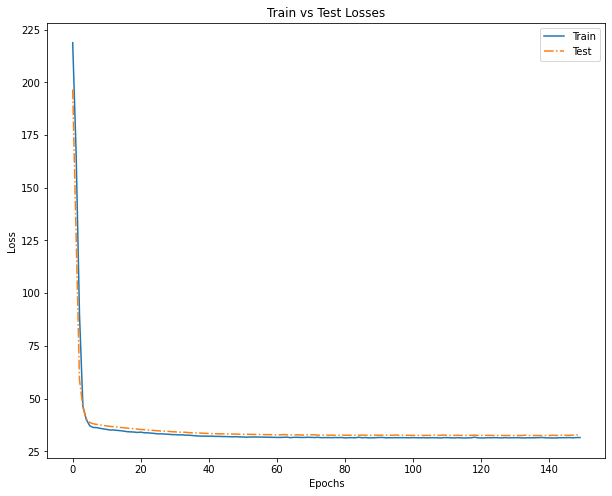

In [ ]:
#create a loss plot
plt.plot(losses_train,'-')
plt.plot(losses_test,'-.')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train','Test'])
plt.title('Train vs Test Losses')
 
plt.show()

In [ ]:
#create an accuracy plot
#plt.plot(accuracies_train,'-')
#plt.plot(accuracies_test,'-.')
#plt.xlabel('Epochs')
#plt.ylabel('Accuracy')
#plt.legend(['Train','Test'])
#plt.title('Train vs Test Accuracy')
 
#plt.show()

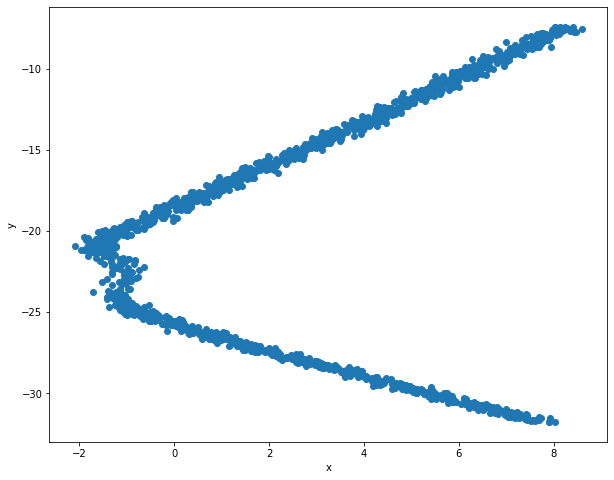

In [ ]:
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(df_visual['x'], df_visual['y'])

In [ ]:
predictions_blind = []
predictions_blind = Result_Cup(model, xtest_tensor)
predictions_blind

[array([[  3., -20.],
        [  3., -20.],
        [  3., -20.],
        ...,
        [  3., -20.],
        [  3., -20.],
        [  3., -20.]], dtype=float32)]

In [ ]:
def plot_coordinates(model, X, true_y = None):
    y_predicted = model.predict(X)
    y_predicted = pd.DataFrame(data=y_predicted, columns=["x", "y"])
    if not None:
        true_y = pd.DataFrame(data=true_y, columns=["x", "y"])
        plt.scatter(true_y['x'], true_y['y'], c='r', marker='*')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.scatter(y_predicted['x'], y_predicted['y'], c='#1f77b4')

In [ ]:
#plot_coordinates(model, X_internal_test, y_internal_test)

In [ ]:
#plot_coordinates(model, X_all, y_all)

In [ ]:
#plot_coordinates(model, blind_ts)
y_predicted = pd.DataFrame(data=predictions_blind, columns=["x", "y"])
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(y_predicted['x'], y_predicted['y'], c='#1f77b4')

ValueError: Must pass 2-d input. shape=(1, 540, 2)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d9d840c9-75b3-4185-bb01-105f5cca8d83' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>